###Install necessary packages

In [1]:
!pip install fuzzywuzzy

In [2]:
# !pip install nltk
!pip install contractions

     |████████████████████████████████| 321 kB 14.4 MB/s 
     |████████████████████████████████| 284 kB 48.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85433 sha256=8ad85110f8ce949e9461c74e2e9e6f9855475933a0b0ce77f6f2a7ab9c73fdfc
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


###Import Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Numerical libraries
import numpy as np   
# to handle data in form of rows and columns 
import pandas as pd    
# importing ploting libraries
import matplotlib.pyplot as plt   

#importing seaborn for statistical plots
import seaborn as sns
import string
from fuzzywuzzy import fuzz

import os

In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, BatchNormalization,SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import zscore

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import string
import contractions
from sklearn.model_selection import train_test_split
from collections import OrderedDict
# this module is for making wordcloud in python
from wordcloud import WordCloud, STOPWORDS 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Mount Drive and Load data file

In [8]:
# mount google drive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [9]:
#Set your project path 

filePath = '/gdrive/MyDrive/AIML2021/projects/Capstone/NLP1/'
fileName = filePath + 'DataSet/input_data automated ticket dataset-12.xlsx'

In [10]:
# reading the xlsx file into pandas dataframe
at_data_df = pd.read_excel(fileName,index_col= None)  

### Exploratory Data Analysis

In [11]:
# display firt 5 data samples
at_data_df.head(5)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [12]:
# summary of descriptive statistics that summarize the central tendency.
at_data_df.describe().transpose()

,count,unique,top,freq
Short description,8492,7481,password reset,38
Description,8499,7817,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
Assignment group,8500,74,GRP_0,3976


In [13]:
# Align datafrme columns
at_data_df.columns=['Short_description', 'Description', 'Caller', 'Assignment_group']

In [14]:
# Display data types and all the columns are of type object as they contain text in each column
at_data_df.dtypes

Short_description    object
Description          object
Caller               object
Assignment_group     object
dtype: object

In [15]:
# Display the null values in the data samples
# Short description has 8 null records
# description has 1 null record

at_data_df.isnull().sum()

Short_description    8
Description          1
Caller               0
Assignment_group     0
dtype: int64

##### Observations

- The Assignment Group column is the target variable and classes among which the incidents will be assigned
- The dataset has total of 8500 samples.
- The 8500 records are distributed across 73 Assignment groups
- Almost 50% of samples belong to one Assignment Group (Group-0) and this means data imbalance between the class
- Few of the Assignment groups 5 to 1 samples and these groups will impact the performance of the Model big time
- As depicted in the Visualisation-1 in section 5, the data is skewed and there is high imbalance between assignment groups (target classes).
3976 incidents were assigned to Assignment Group-0 and this is majority group
- There are two groups with only 1 record of data sample

- Data is highly imbalanced between Group-0 and Rest of the Assignment Groups

- Data imbalance will be impacting the Model performance and it will be biased towards majority classes

### Feature Engineering

In [17]:
# Data sampling with Replacement
# Used Sklearn Utils Resample
# Up-Sampling the Minority groups
# tested the model with tuning the value count parameter and works better

from sklearn.utils import resample

at_data_majority = at_data_df[at_data_df['Assignment_group'].isin(at_data_df['Assignment_group'].value_counts()[at_data_df['Assignment_group'].value_counts() > 70].index)]
at_data_minority = at_data_df[at_data_df['Assignment_group'].isin(at_data_df['Assignment_group'].value_counts()[at_data_df['Assignment_group'].value_counts() < 70].index)]

print(at_data_majority.shape)
# print(at_data_minority.shape)

at_data_minority_upsampled = resample(at_data_minority,
                                 replace=True,    
                                 n_samples=len(at_data_majority),
                                #  stratify=True,
                                 random_state=123)

print(at_data_minority.shape)

at_data_upsampled = pd.concat([at_data_minority, at_data_majority])
#at_data_upsampled['Assignment_group'].value_counts()
print(at_data_upsampled.shape)

(7481, 4)
(1019, 4)
(8500, 4)


In [ ]:
# Copy the upsampled data set into original data frame
#at_data_df = at_data_upsampled.copy()

In [18]:
at_data_ups_df = at_data_upsampled.copy()

In [19]:
# Replace Nan values in Short_description and Description to THE - since this stop word will be eliminated in the vectorization
at_data_ups_df.Description.fillna("The", inplace=True)
at_data_ups_df.Short_description.fillna("The", inplace=True)

In [20]:
# Drop the rows that have null values in Assignment Groups
at_data_ups_df = at_data_ups_df.dropna(subset=["Assignment_group"])

In [21]:
# Drop the Caller Column
at_data_ups_df = at_data_ups_df.drop(['Caller'], 1)

In [22]:
# Insert 2 new Columns for Fuzzy Rating and Combined Description

at_data_ups_df.insert(3, 'fuzzy_Rating', '0')
at_data_ups_df.insert(4, 'Combined_Description', '0')

In [23]:
# Display top 5 records after upsampling

at_data_ups_df.head(5)

,Short_description,Description,Assignment_group,fuzzy_Rating,Combined_Description
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,GRP_1,0,0
49,status does not change on telephony_software,"when closing a call, the agent keeps on the ""o...",GRP_7,0,0
84,engineering tool drawing originals in pdf form...,"hello it service,\r\ni need to monitor the man...",GRP_11,0,0
141,channel partner receiving multiple emails from...,"hi,\nour channel partner with the email addres...",GRP_15,0,0
185,data not correctly pulled for all the employee...,data not correctly pulled for all the employee...,GRP_20,0,0


In [24]:
# Calcuate the Fuzzy Rating for each row between Short Description and Description

for i in at_data_ups_df.index:
  at_data_ups_df.fuzzy_Rating[i] = fuzz.ratio(str(at_data_ups_df.values[i][0]),str(at_data_ups_df.values[i][1]))

In [25]:
# Combine Description and Short Description text based on the Fuzzy Rating

for i in at_data_ups_df.index:
    if at_data_ups_df.fuzzy_Rating[i] is 100:
      at_data_ups_df.Combined_Description[i] = str(at_data_ups_df.Short_description[i])
    else:
      at_data_ups_df.Combined_Description[i] = str(at_data_ups_df.Short_description[i]) + str(at_data_ups_df.Description[i])

In [26]:
# Display top 5 records to see the new columns

at_data_ups_df.head()

,Short_description,Description,Assignment_group,fuzzy_Rating,Combined_Description
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,GRP_1,11,event: critical:HostName_221.company.com the v...
49,status does not change on telephony_software,"when closing a call, the agent keeps on the ""o...",GRP_7,14,status does not change on telephony_softwarewh...
84,engineering tool drawing originals in pdf form...,"hello it service,\r\ni need to monitor the man...",GRP_11,29,engineering tool drawing originals in pdf form...
141,channel partner receiving multiple emails from...,"hi,\nour channel partner with the email addres...",GRP_15,30,channel partner receiving multiple emails from...
185,data not correctly pulled for all the employee...,data not correctly pulled for all the employee...,GRP_20,72,data not correctly pulled for all the employee...


In [27]:
# Handling punctuations

cd = [""]
for combinedDescription in at_data_ups_df.Combined_Description:
    cd.append(combinedDescription)

cdToStr = ' '.join([str(elem) for elem in cd])

punc = ""
for i in cdToStr:        
  if i in string.punctuation:
    punc = punc + i + ","

puncList = punc.split(',')
print("Unique Punctuations in data are : ", np.unique(puncList))

Unique Punctuations in data are :  ['' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' '-' '.' '/' ':' ';' '<'
 '=' '>' '?' '@' '[' '\\' ']' '^' '_' '`' '{' '|' '}' '~']


In [28]:
# Initialise the Stemming and Lemmitization functions

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

In [29]:
# Derive and Insert new column to store number of Digits in each row

at_data_ups_df["Desc_1_ndigits"] = at_data_ups_df["Combined_Description"].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [30]:
# Derive and Insert new column to store number of Word Count in each row

at_data_ups_df["Desc_1_count"] = at_data_ups_df["Combined_Description"].apply(lambda x: len(str(x).split(" ")))

In [31]:
# Derive and store more frequent words in an array

description_most_freq_words = pd.Series(" ".join(at_data_ups_df["Combined_Description"]).split()).value_counts()

In [32]:
### Least frequent words in description
description_least_freq_words =  pd.Series(" ".join(at_data_ups_df["Combined_Description"]).split()).value_counts().sort_values(ascending = True)

In [33]:
### Most frequent words in description
description_1_most_freq_words = pd.Series(" ".join(at_data_ups_df["Combined_Description"]).split()).value_counts()

In [34]:
# Display number of digits vs combined description column
at_data_ups_df[["Combined_Description","Desc_1_ndigits"]].sort_values(by = "Desc_1_ndigits",ascending = False).head()

,Combined_Description,Desc_1_ndigits
7345,security incidents - ( sw #in33501789 ) : broa...,457
5433,security incidents - ( #in33765965 ) : possibl...,250
3706,security incidents - ( #in33924718 ) : possibl...,156
3965,security incidents - ( #in33809307 ) : possibl...,154
4730,security incidents - ( #in33847938) : possibl...,154


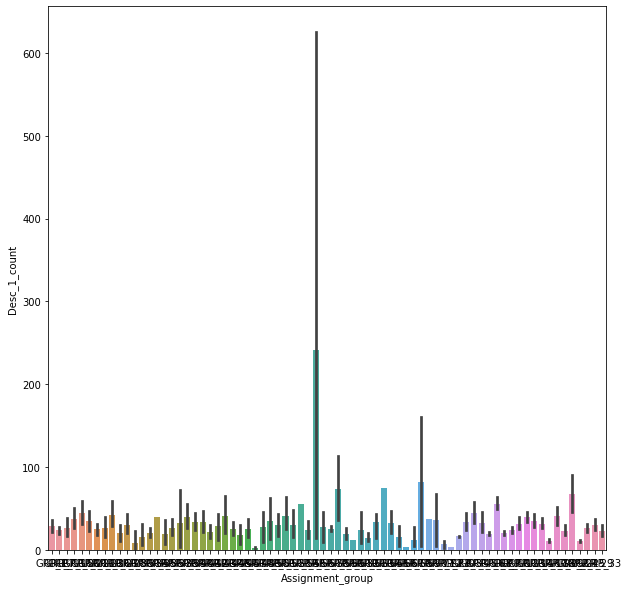

In [35]:
# Plot grah to show the word count by Assignment groups

plt.figure(figsize=(10,10))
sns.barplot(x=at_data_ups_df['Assignment_group'],y=at_data_ups_df['Desc_1_count'],data=at_data_ups_df)

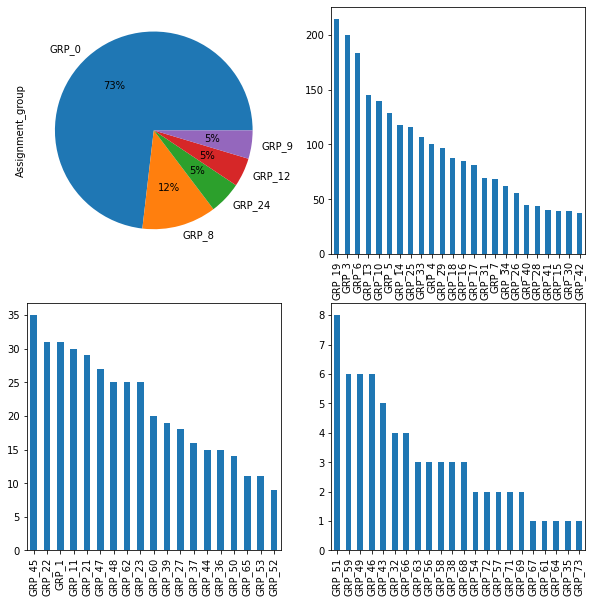

In [36]:
# Plot graphs to visualize the word count by Assignment groups in to 4 sections
# sectoin 1 between 0 to 5 top count
# sectoin 2 between 6 to 30 top count
# sectoin 3 between 31 to 50 top count
# sectoin 2 between 51 to 73 top count

fig,axs = plt.subplots(2,2, sharex=False, figsize=(10,10))

at_data_ups_df['Assignment_group'].value_counts()[0:5].plot(kind='pie', autopct='%1.0f%%', ax=axs[0, 0])
at_data_ups_df['Assignment_group'].value_counts()[6:30].plot(kind='bar', ax=axs[0, 1])
at_data_ups_df['Assignment_group'].value_counts()[31:50].plot(kind='bar', ax=axs[1, 0])
at_data_ups_df['Assignment_group'].value_counts()[51:73].plot(kind='bar', ax=axs[1, 1])

plt.show()

#### Observations
- As there is no relation between Caller column and the other columns, the caller column is dropped.
- As both short description and description have similar or same text in many cases, we used a package named fuzzywuzzy and its function to identify the fuzzy score (by comparing the words in two strings).
- If the two strings (short description and description) are same, the score will be very high, and a conditional statement is applied not to merge / concatenate the columns and take only one of the two column values. If the fuzzy score is less, then both the texts are concatenated.
- This is the method used to build the corpus (Combination of Short Description & description).

#### Word Cloud before data processing

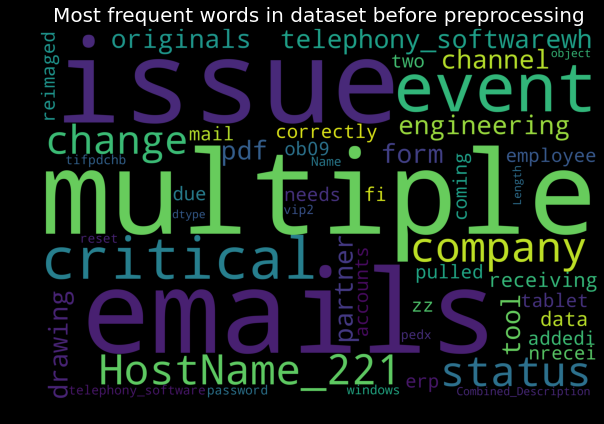

In [38]:
# define wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS)

# generate word cloud for data before preprocessing
wc_word=wc.generate(str(at_data_ups_df.Combined_Description))
print(wc_word)

# declare our figure 
plt.figure(figsize=(10,10), facecolor='k')

# add title to the graph
plt.title("Most frequent words in dataset before preprocessing", fontsize=20,color='white')
plt.imshow(wc_word)
plt.show()

### Data Pre-processing
- Handling of missing Records
- Handling of special characters
- Handling of contractions text
- Handling of URL, IP address, numbers
- Handling of multilingual text
- Handling of whitespace/newline
- Handling of stopwords
- Identification of maxlen and minlen

In [39]:
#function to preprocess data 
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = contractions.fix(sentence)
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_email = re.sub('\S+@+\S+[.com]','',cleantext)
    rem_special = re.sub(r'[_"\-;%()|~^+&=*%.,!?:#$@\[\]/]', ' ', rem_email)    
    rem_url=re.sub(r'http\S+', '',rem_special)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    # filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [40]:
# Run preprocessing for combined description data set
cleaner_Description = []
for combinedDescription in at_data_ups_df.Combined_Description:
    cleaner_Description.append(preprocess(combinedDescription))

#### Word Cloud after data processing

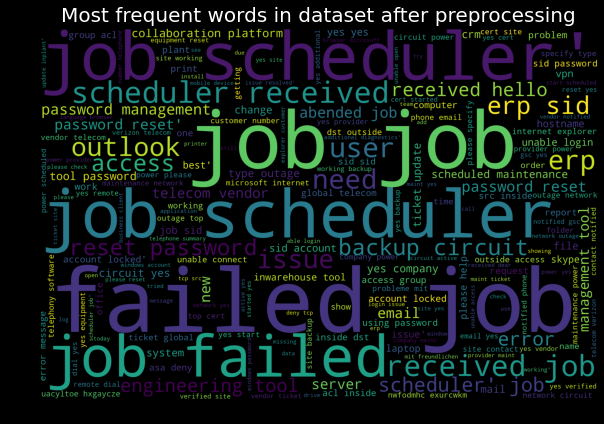

In [41]:
# define wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS)

# generate word cloud for preprocessed data
wc_word=wc.generate(str(cleaner_Description))
print(wc_word)

# declare our figure 
plt.figure(figsize=(10,10), facecolor='k')

# add title to the graph
plt.title("Most frequent words in dataset after preprocessing", fontsize=20,color='white')
plt.imshow(wc_word)
plt.show()

#### Get the Length of each line and find min and max length

In [42]:
# Display the Maximum word count length in the new corpus

combined_description_maxlen = max([len(x.split()) for x in cleaner_Description])
print("Max length of words in the data is : ",combined_description_maxlen)

Max length of words in the data is :  767


Combined_Description length: 
Mean 110.59 words (204.223967)


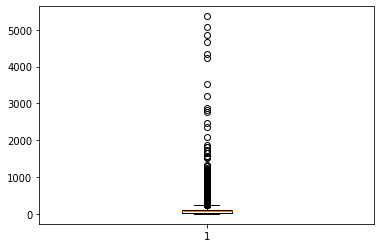

In [43]:
# Summarize Combined_Description length
print("Combined_Description length: ")
# result = [len(x) for x in data_df.Combined_Description]
result = [len(x) for x in cleaner_Description]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

In [44]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
y = label_encoder.fit_transform(at_data_ups_df.Assignment_group)

X = cleaner_Description

#### Strategy for Maxlen
- The word count ranges between 800 to 10
- The Word count for majority of data samples is below 300
- After analyzing the word count, considered a max sequence length 150
- Tested the model between 250 to 100 for max length